<a href="https://colab.research.google.com/github/yaeliavni/Applied-Statistics/blob/main/IBMhrAnalyticEmployeeExperience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import lifelines
from google.colab import files
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter, statistics, WeibullFitter, NelsonAalenFitter
from lifelines.plotting import plot_lifetimes
from scipy.stats import expon, weibull_min
from lifelines.statistics import proportional_hazard_test

In [ ]:
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition (1).csv


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Shape: (1470, 35)

Missing values per column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany         

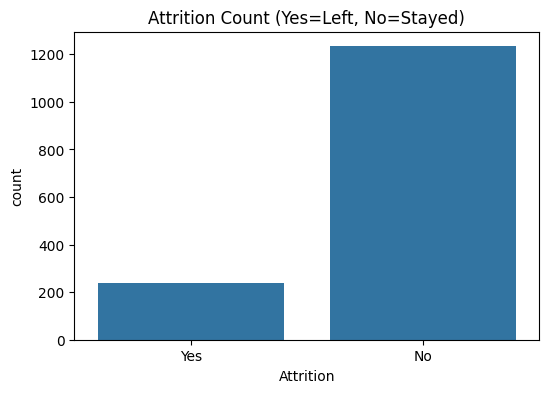

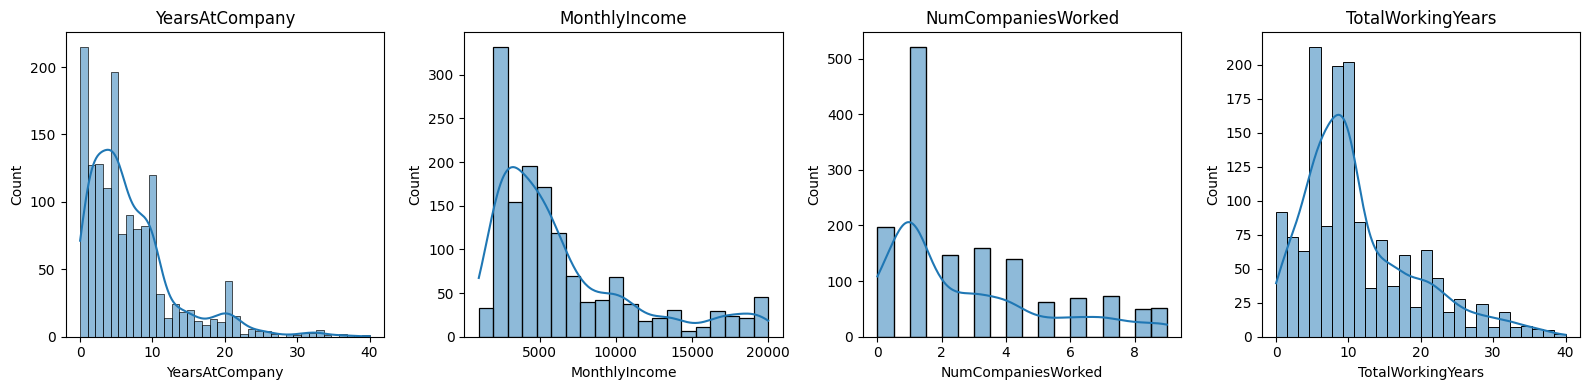


Number of outliers per numeric column:
 MonthlyIncome         114
YearsAtCompany        104
TotalWorkingYears      63
NumCompaniesWorked     52
dtype: int64

Columns available for modeling:
 ['Age', 'Attrition', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'DailyRate', 'Department_Research & Development', 'Department_Sales', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EnvironmentSatisfaction', 'Gender_Male', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MonthlyIncome', 'MonthlyIncome_log', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'OverTime_flag', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [ ]:
# EDA and preprep

print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe().T)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Attrition')
plt.title("Attrition Count (Yes=Left, No=Stayed)")
plt.show()
num_cols = ['YearsAtCompany','MonthlyIncome','NumCompaniesWorked','TotalWorkingYears']
fig, axs = plt.subplots(1, len(num_cols), figsize=(4*len(num_cols),4))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axs[i])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) |
            (df[num_cols] > (Q3 + 1.5*IQR))).sum().sort_values(ascending=False)
print("\nNumber of outliers per numeric column:\n", outliers)

df['MonthlyIncome_log'] = np.log1p(df['MonthlyIncome'])
df['OverTime_flag'] = df['OverTime'].map({'Yes':1,'No':0}).astype(int)

# only one‐hot encode the originals
cat_to_encode = [c for c in ['BusinessTravel','Department','Gender','MaritalStatus']
                 if c in df.columns]
if cat_to_encode:
    df = pd.get_dummies(df,
                        columns=cat_to_encode,
                        drop_first=True)

to_drop = ['EmployeeNumber','Over18','StandardHours']
available = sorted([c for c in df.columns if c not in to_drop])
print("\nColumns available for modeling:\n", available)


Original column names: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Cleaned  column namess: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 

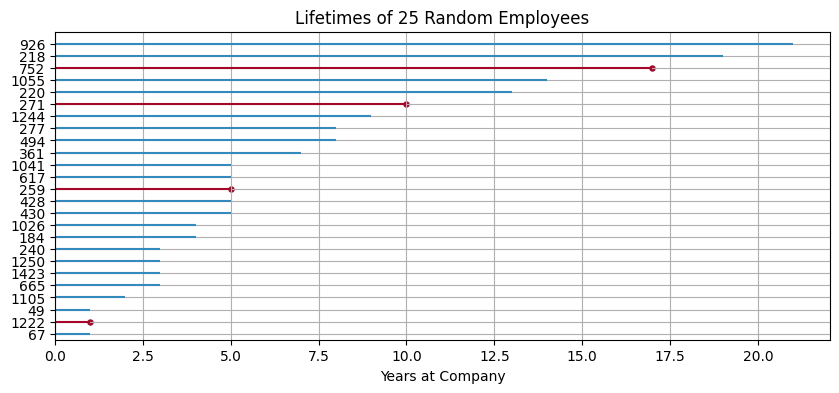

In [ ]:
fname = list(uploaded.keys())[0]
df = pd.read_csv(fname)

print("Original column names:", df.columns.tolist())
df.columns = df.columns.str.strip()
print("Cleaned  column namess:", df.columns.tolist())

df['duration'] = df['YearsAtCompany'].astype(float)
df['event']    = (df['Attrition'].astype(str).str.strip().str.lower() == 'yes').astype(int)


df2 = df.sample(25, random_state=42)
plt.figure(figsize=(10,4))
plot_lifetimes(df2['duration'], df2['event'])
plt.title('Lifetimes of 25 Random Employees')
plt.xlabel('Years at Company')
plt.grid(True)
plt.show()

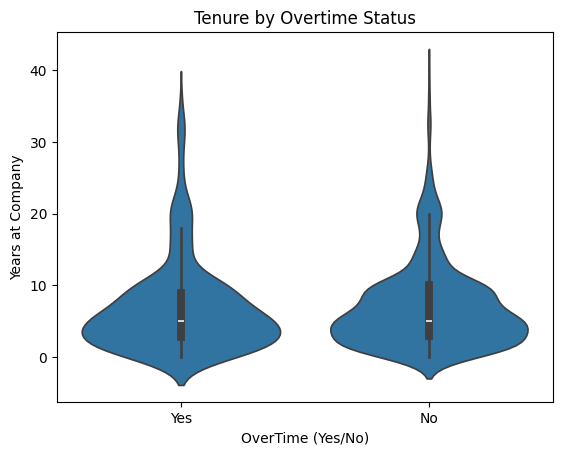

In [ ]:
#  התפלגות הקביעות לפי סטטוס שעות נוספות
sns.violinplot(x='OverTime', y='duration', data=df)
plt.title('Tenure by Overtime Status')
plt.xlabel('OverTime (Yes/No)')
plt.ylabel('Years at Company')
plt.show()

Both median is around 5–6 years. The box spans roughly 2–10 years for both overtime and non-overtime.
The full violin goes from 0 up to ~40 years, with a few long-tenured “outliers” especially among the overtime group.

הצורה של "שעות נוספות = כן" קצת יותר רחב באזור של 4–8 שנים, מה שמרמז שיש שם ריכוז קל של עובדים עם ותק גבוה יחסית.

בקבוצת "שעות נוספות = לא" יש צפיפות קצת יותר גבוהה בטווח של 2–6 שנים, אבל חוץ מזה – הצורה הכללית די דומה בין שתי הקבוצות.

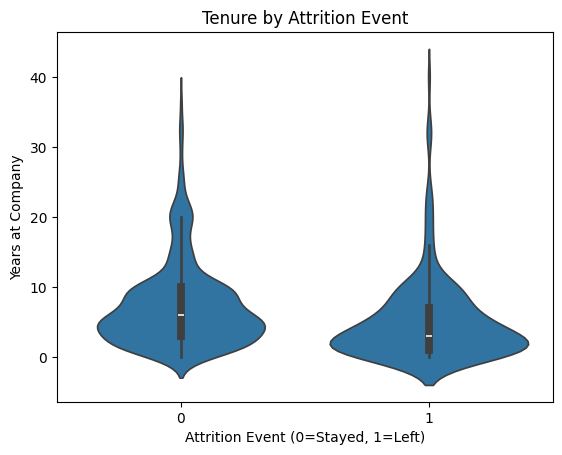

In [ ]:
# קביעות לפי זמן עזיבת החברה (0=censored, 1=left)
sns.violinplot(x='event', y='duration', data=df)
plt.title('Tenure by Attrition Event')
plt.xlabel('Attrition Event (0=Stayed, 1=Left)')
plt.ylabel('Years at Company')
plt.show()

רוב מי שעוזב עושה את זה כבר בשנים הראשונות.
ככל שעובר הזמן, הסיכון לעזיבה כנראה יורד

הגרף הזה מאשש את ההיגיון, ככל שיש לעובד יותר ותק, כך קטן הסיכוי שייעזוב, וזה גם מסביר למה הגרף של הlifelines  צונחות כל כך חזק בהתחלה.

Exponential vs Weibull MLE on “control” subgroup

Exponential fit → loc=0.000, scale=5.682


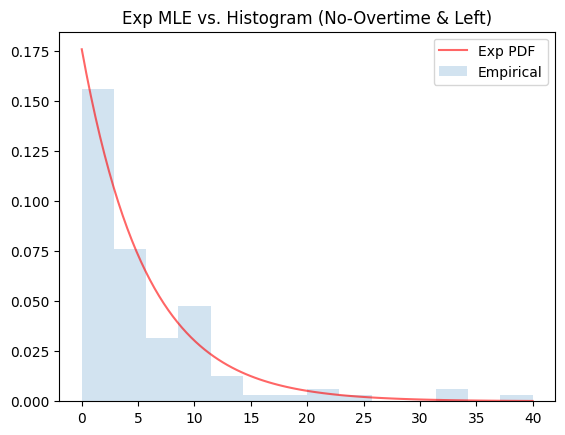

In [ ]:
# “control” is those NOT working overtime
control   = df[df['OverTime']=='No']
observed  = control[control['event']==1]  # only those who actually left before we stopped collecting data זה מסומלץ אבל אם היה אמיתי

loc, scale = expon.fit(observed['duration'])
RV_exp = expon(loc=loc, scale=scale)
print(f"Exponential fit → loc={loc:.3f}, scale={scale:.3f}")

x = np.linspace(control['duration'].min(), control['duration'].max(), 100)
plt.plot(x, RV_exp.pdf(x), 'r-', alpha=0.6, label='Exp PDF')
plt.hist(observed['duration'], density=True, bins='auto',
         histtype='stepfilled', alpha=0.2, label='Empirical')
plt.title('Exp MLE vs. Histogram (No‐Overtime & Left)')
plt.legend()
plt.show()

משך הזמן הממוצע עד שעובדים (שלא עשו שעות נוספות ובסופו של דבר עזבו) עוזבים את
החברה הוא כ-5.68 שנים.

the assumption that it distibutes exp is accurate in our case!


Weibull fit params (c, loc, scale): (np.float64(0.9652617408921806), 0, np.float64(5.561538732219006))


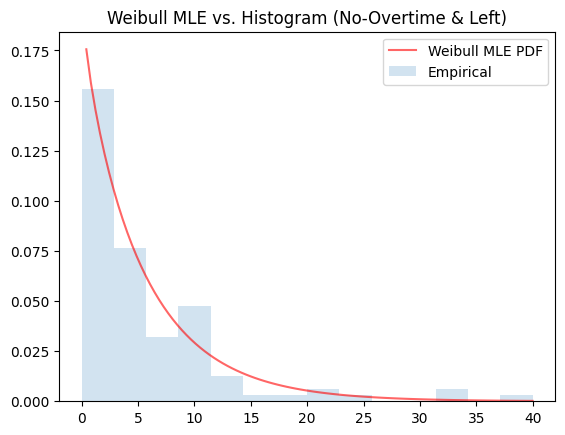

In [ ]:
# Weibull fit (forced loc=0) like we did in the lecture:)
params = weibull_min.fit(observed['duration'], floc=0)
RV_wb  = weibull_min(*params)
print("Weibull fit params (c, loc, scale):", params)

plt.plot(x, RV_wb.pdf(x), 'r-', alpha=0.6, label='Weibull MLE PDF')
plt.hist(observed['duration'], density=True, bins='auto',
         histtype='stepfilled', alpha=0.2, label='Empirical')
plt.title('Weibull MLE vs. Histogram (No‐Overtime & Left)')
plt.legend()
plt.show()

Since c < 1, this suggests a decreasing hazard rate, meaning:

Employees in this group are most likely to leave early on, and the longer they stay, the less likely they are to leave.

The scale ≈ 5.56 is close to the exponential model’s mean (5.68), confirming that the average time to exit is around 5.5–5.7 years for this group.

So the Weibull model adds an important nuance: while the exponential model assumes constant risk over time, this one captures that risk drops the longer someone sticks around.

In [ ]:
# only keep who left (event==1) under our supervision (or the data collectors)
observed = df.loc[df['event']==1, 'duration']

# drop exact zeros (so Weibull logpdf doesn’t blow up)
observed = observed[ observed > 0 ].values
n_obs = len(observed)

# fit an Exponential (constant hazard) and like before force location = 0 because some people left the job before or during the first day
loc_exp = 0
# MLE for scale is just the sample mean from statictical inference
scale_exp = observed.mean()
LL_exp = np.sum(expon.logpdf(observed, loc=loc_exp, scale=scale_exp))

# fit a Weibull - estimate (c - מגמה, scale - רוחב)
c_wb, loc_wb, scale_wb = weibull_min.fit(observed, floc=0)
LL_wb = np.sum(weibull_min.logpdf(observed, c_wb, loc=loc_wb, scale=scale_wb))

print(f"Log-Lik:   Exp = {LL_exp:.1f},   Weibull = {LL_wb:.1f}")

#  AIC & BIC
# # of parameters: Exp has 1 (scale) when loc fixed; Weibull has 2 (shape c + scale)
k_exp = 1
k_wb  = 2

AIC_exp = 2*k_exp  - 2*LL_exp
BIC_exp = k_exp*np.log(n_obs) - 2*LL_exp

AIC_wb  = 2*k_wb   - 2*LL_wb
BIC_wb  = k_wb * np.log(n_obs) - 2*LL_wb

print(f"AIC:  Exp = {AIC_exp:.1f},  Weibull = {AIC_wb:.1f}")
print(f"BIC:  Exp = {BIC_exp:.1f},  Weibull = {BIC_wb:.1f}")

better_ll  = "Weibull"  if LL_wb  > LL_exp  else "Exponential"
better_aic = "Weibull"  if AIC_wb <  AIC_exp else "Exponential"
better_bic = "Weibull"  if BIC_wb <  BIC_exp else "Exponential"

print("\nModel preferred by metric:")
print(f"  • Log-Likelihood:   {better_ll} (higher is better)")
print(f"  • AIC:              {better_aic} (lower is better)")
print(f"  • BIC:              {better_bic} (lower is better)")


Log-Lik:   Exp = -597.8,   Weibull = -597.1
AIC:  Exp = 1197.7,  Weibull = 1198.3
BIC:  Exp = 1201.1,  Weibull = 1205.1

Model preferred by metric:
  • Log-Likelihood:   Weibull (higher is better)
  • AIC:              Exponential (lower is better)
  • BIC:              Exponential (lower is better)


chat: does that mean they are super close so they are both good?


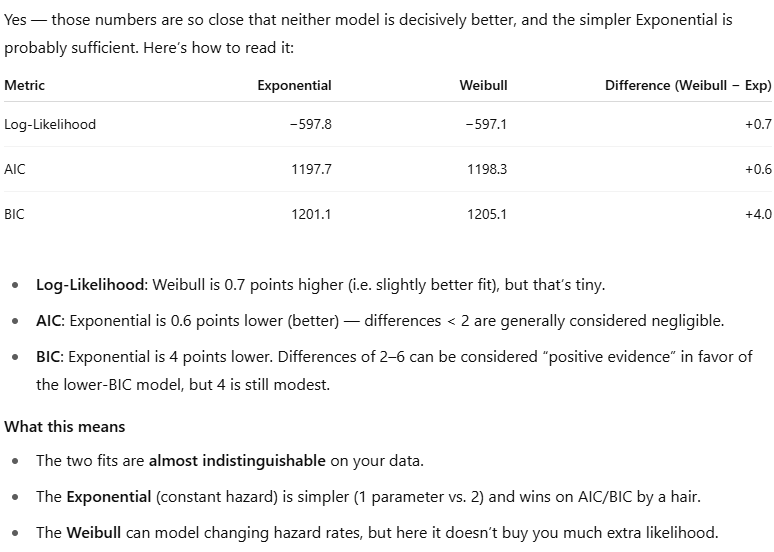

lifelines Weibull → ρ=0.989, λ=73.068


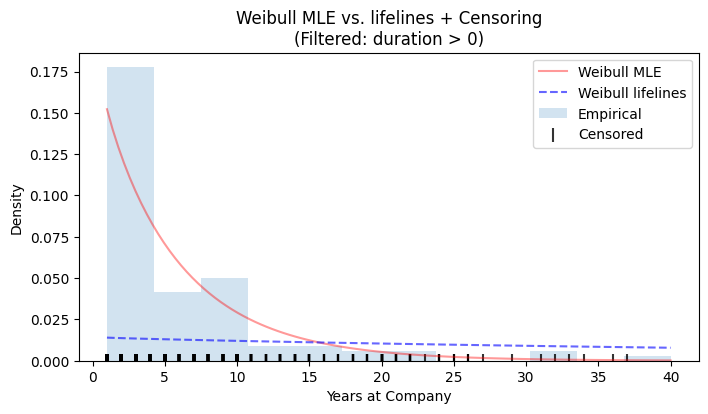

In [ ]:
#Parametric Weibull via lifelines (filter out zero‐duration entries)

# Remove zero-duration rows (cannot fit Weibull with non-positive durations)
control_pos = control.loc[control['duration'] > 0].copy()
observed_pos = control_pos[control_pos['event'] == 1]

# Fit Weibull to the positive-duration subset
wf = WeibullFitter()
wf.fit(control_pos['duration'], event_observed=control_pos['event'])

rho_, lambda_ = wf.rho_, wf.lambda_
print(f"lifelines Weibull → ρ={rho_:.3f}, λ={lambda_:.3f}")

# Recompute x over the filtered range
x_pos = np.linspace(control_pos['duration'].min(), control_pos['duration'].max(), 100)

# PDF from lifelines parameters
pdf_ll = (rho_ / lambda_) * (x_pos / lambda_)**(rho_ - 1) * np.exp(-(x_pos / lambda_)**rho_)

# Plot comparison
plt.figure(figsize=(8,4))
plt.plot(x_pos, RV_wb.pdf(x_pos), 'r-', alpha=0.4, label='Weibull MLE')
plt.plot(x_pos, pdf_ll,    'b--',alpha=0.6, label='Weibull lifelines')
plt.hist(observed_pos['duration'], density=True, bins='auto',
         histtype='stepfilled', alpha=0.2, label='Empirical')

# Mark censored (positive-duration but no event)
censored_pos = control_pos[control_pos['event'] == 0]
plt.scatter(censored_pos['duration'], np.zeros_like(censored_pos['duration']),
            marker='|', color='k', label='Censored', s=100, alpha=0.8)

plt.title('Weibull MLE vs. lifelines + Censoring\n(Filtered: duration > 0)')
plt.xlabel('Years at Company')
plt.ylabel('Density')
plt.legend()
plt.show()


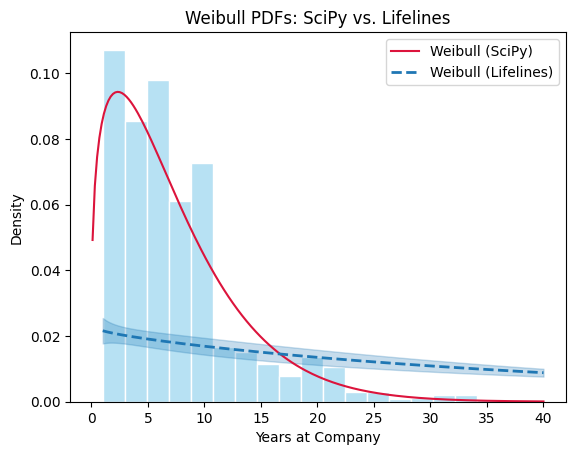

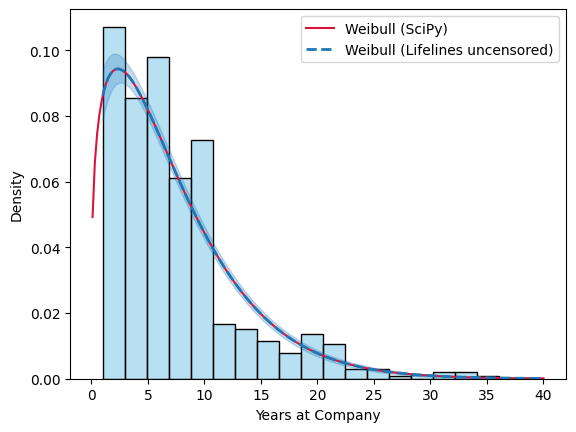

In [ ]:

mask = (df['duration'] > 0)
dur = df.loc[mask, 'duration']
evt = df.loc[mask, 'event']

wf = WeibullFitter()
wf.fit(durations=dur, event_observed=evt, label="Weibull (Lifelines)")

c_scipy, loc_scipy, scale_scipy = weibull_min.fit(dur.values, floc=0)

t = np.linspace(0.1, dur.max(), 200)

ax = sns.histplot(
    dur,
    stat="density",
    bins=20,
    color="skyblue",
    edgecolor="white",
    alpha=0.6
)

pdf_scipy = weibull_min.pdf(t, c_scipy, loc=0, scale=scale_scipy)
ax.plot(t, pdf_scipy, color="crimson", label="Weibull (SciPy)")
wf.plot_density(ax=ax, linestyle="--", linewidth=2)

ax.set_xlabel("Years at Company")
ax.set_ylabel("Density")
ax.set_title("Weibull PDFs: SciPy vs. Lifelines")
ax.legend()
plt.show()

dur = df.loc[df['duration']>0, 'duration'].values
wf_uncens = WeibullFitter()
wf_uncens.fit(durations=dur,
              event_observed=np.ones_like(dur, dtype=int),
              label="Weibull (Lifelines uncensored)")
ax = sns.histplot(dur, stat="density", bins=20, color="skyblue", alpha=0.6)
t = np.linspace(0.1, dur.max(), 200)
ax.plot(t, weibull_min.pdf(t, c_scipy, loc=0, scale=scale_scipy),
        color="crimson", label="Weibull (SciPy)")

wf_uncens.plot_density(ax=ax, linestyle="--", linewidth=2)

ax.set_xlabel("Years at Company")
ax.set_ylabel("Density")
ax.legend()
plt.show()


Non parametic approach


Empirical CDF

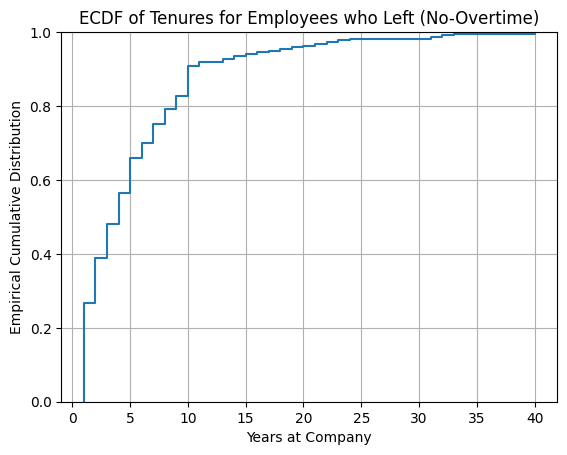

In [ ]:
# pick only the people\samples that left (events) the work place
dur_left = df.loc[(df['event']==1) & (df['duration']>0), 'duration']

sns.ecdfplot(dur_left)
plt.title('ECDF of Tenures — Left Employees')
plt.xlabel('Years at Company')
plt.ylabel('Empirical Cumulative Distribution')
plt.grid(True)
plt.show()


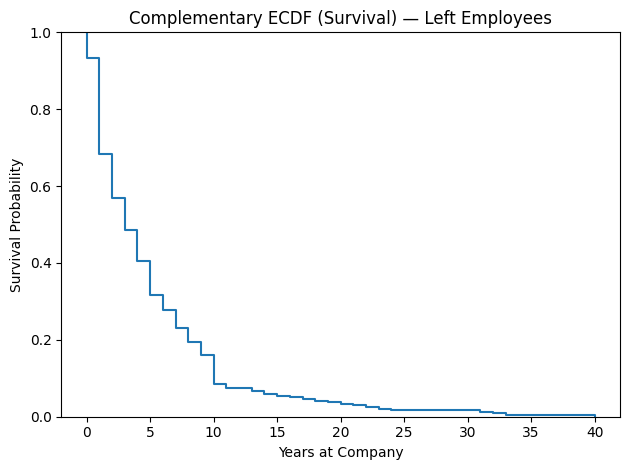

In [ ]:
ax = sns.ecdfplot(df.loc[df['Attrition'].eq('Yes'), 'YearsAtCompany'], complementary=True)
ax.set_title("Complementary ECDF (Survival) — Left Employees")
ax.set_xlabel("Years at Company"); ax.set_ylabel("Survival Probability")
plt.tight_layout(); plt.show()


What about censored data? KM

          No-Overtime KM
timeline                
0.0             0.994307
1.0             0.964206
2.0             0.951463
3.0             0.944467
4.0             0.930197


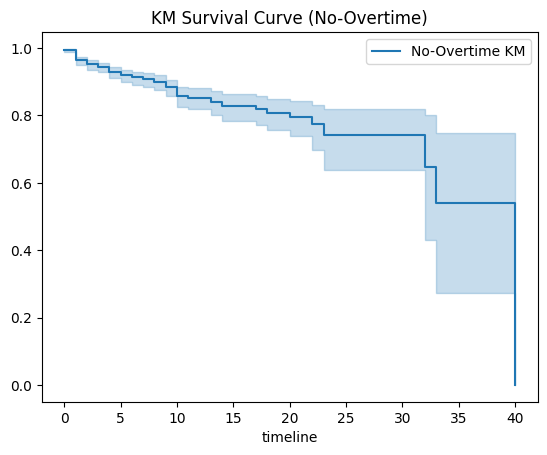

In [ ]:
# Kaplan–Meier - Survival Function estimation
kmf = KaplanMeierFitter()
kmf.fit(control['duration'], control['event'], label='No-Overtime KM')
print(kmf.survival_function_.head())
kmf.plot_survival_function()
plt.title('KM Survival Curve (No-Overtime)')
plt.show()

For the comulative hazard estimation


Model the cumulative hazard = $\int_0^th(x)dx$.

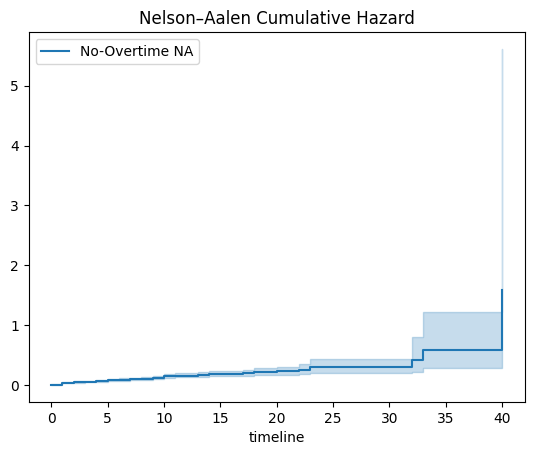

In [ ]:
# Nelson–Aalen - Hazard Function estimator
naf = NelsonAalenFitter()
naf.fit(control['duration'], control['event'], label='No-Overtime NA')
naf.plot_cumulative_hazard()
plt.title('Nelson–Aalen Cumulative Hazard')
plt.show()

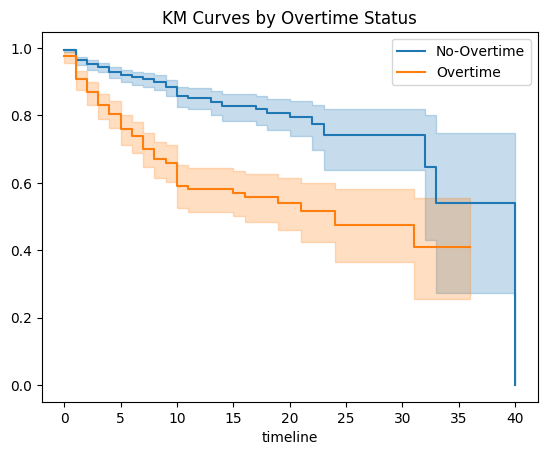

In [ ]:
# ────────────────
# 5) Multiple‐group KM & Cox PH
# ────────────────
# KM curves by OverTime
mask = df['OverTime']=='Yes'
km0 = KaplanMeierFitter().fit(df.loc[~mask,'duration'], df.loc[~mask,'event'], label='No-Overtime')
ax  = km0.plot_survival_function()
km1 = KaplanMeierFitter().fit(df.loc[mask,'duration'], df.loc[mask,'event'], label='Overtime')
km1.plot_survival_function(ax=ax)
plt.title('KM Curves by Overtime Status')
plt.show()




talk about the overlapping lines and CI
and we don't have any observation of overtime line beyond the 35 years

In [ ]:
# --- Cox PH with stratification by IncomeQuartile ---
df2 = df[['duration','event','OverTime','JobSatisfaction','MonthlyIncome']].copy()
df2['OverTime_flag'] = df2['OverTime'].map({'No':0,'Yes':1})
df2['JobSatisfaction'] = pd.to_numeric(df2['JobSatisfaction'], errors='coerce')
df2['IncomeQuartile'] = pd.qcut(df2['MonthlyIncome'], q=4, labels=['Q1','Q2','Q3','Q4'])
df2 = df2.drop(columns=['OverTime','MonthlyIncome']).dropna()

cph = CoxPHFitter()
cph.fit(
    df2,
    duration_col='duration',
    event_col='event',
    strata=['IncomeQuartile'],
    formula="OverTime_flag + JobSatisfaction"
)
cph.print_summary()


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                   strata = IncomeQuartile
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1190.56
         time fit was run = 2025-08-31 18:36:43 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
OverTime_flag    1.13      3.08      0.13            0.87            1.38                2.38                3.99
JobSatisfaction -0.23      0.79      0.06           -0.35           -0.12                0.71                0.89

                 cmp to     z      p  -log2(p)
covariate                                     
OverTime_flag      0.00  8.59 <0.005     56.69
JobSatisfaction    0.00 -3.96 <0.005     13.71
---
Concordance = 0.68
Partial AIC = 2385.13
log-likelihood ratio test = 88.29 on 2 df
-log2(p) of ll-ratio test = 63.69

* on the record there are 1,470 employees total, of whom 237 actually left (events).
* exp(coef) = 3.08 → at any given tenure, overtime workers are about 3× more likely to depart than non-overtime staff (holding job satisfaction constant).
* Concordance = 0.68 means the model correctly orders “who leaves first” about 68 %
* breslow estimation of the survival function was used per quarter, so four seperate baselines.

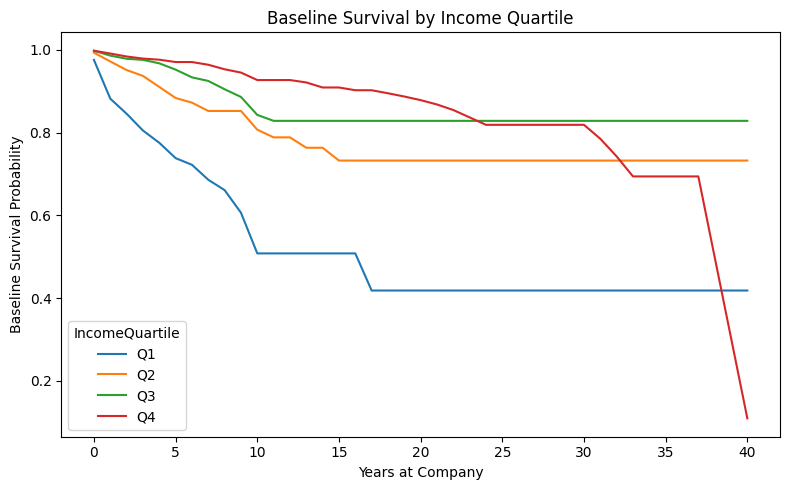

where Q1 is the lowest income employees


In [ ]:
ax = cph.baseline_survival_.plot(figsize=(8,5))
ax.set_title("Baseline Survival by Income Quartile")
ax.set_xlabel("Years at Company")
ax.set_ylabel("Baseline Survival Probability")
ax.legend(title="IncomeQuartile")
plt.tight_layout()
plt.show()
print("where Q1 is the lowest income employees")

Q4 > Q3 > Q2 > Q1 holds, confirming that higher pay is tightly linked to more time at the work place, where as of 22-23 it shifts entirely (maybe because they can allow themself to retire\ invent something?)

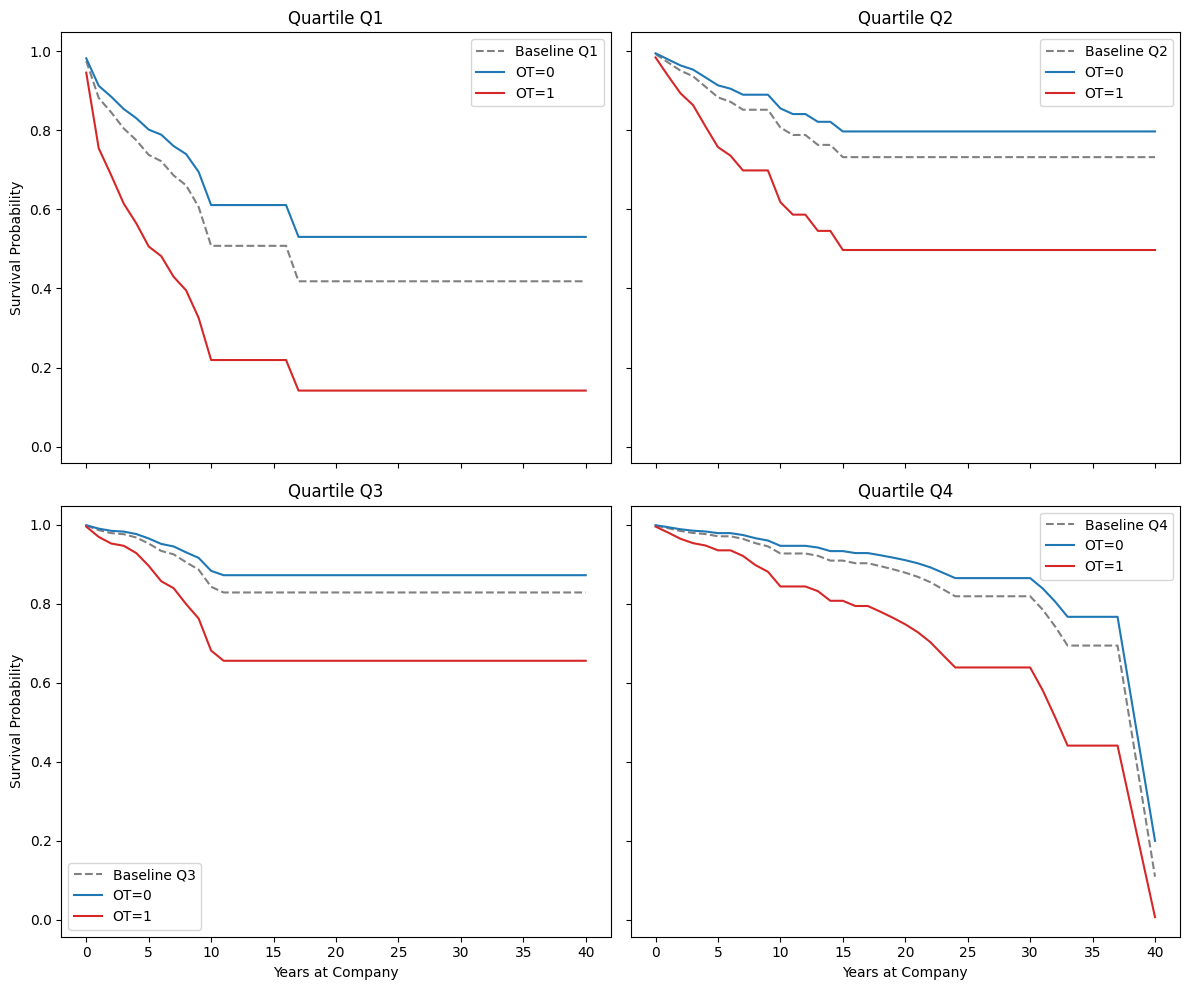

In [ ]:
# assume cph_strat is your stratified CoxPHFitter from above
quartiles = ['Q1','Q2','Q3','Q4']
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for ax, quart in zip(axes.flat, quartiles):
    cph.baseline_survival_[quart].plot(
        ax=ax,
        linestyle="--",
        color="gray",
        label=f"Baseline {quart}"
    )

    # plotting the predicted survival for OT=0 and OT=1 while we hold JobSatisfaction at its mean for a “typical” profile.
    mean_js = df2['JobSatisfaction'].mean()
    for ot_flag, color in zip([0, 1], ["tab:blue", "tab:red"]):
        X = pd.DataFrame({
            "OverTime_flag": [ot_flag],
            "JobSatisfaction": [mean_js],
            "IncomeQuartile": [quart]   # ensures we use the correct one
        })
        surv = cph.predict_survival_function(X)
        ax.plot(
            surv.index,
            surv.iloc[:, 0],
            color=color,
            label=f"OT={ot_flag}"
        )

    ax.set_title(f"Quartile {quart}")
    ax.set_xlabel("Years at Company")
    ax.set_ylabel("Survival Probability")
    ax.legend()

plt.tight_layout()
plt.show()


בכל רמות השכר, עבודה בשעות נוספות מגדילה באופן חד את הסיכוי שהעובדים יעזבו—בעובדים בשכר הנמוך (רבעונים 1 ו-2) הירידה בשימור היא החדה ביותר בתחילת הקריירה, בעוד שבעלי השכר הגבוה (רבעונים 3 ו-4) מתחילים משיעור שימור גבוה יותר אך גם אצלם נצפתה עלייה של כ-15–25 % בעזיבה בעקבות השעות הנוספות.



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

=== KM‐transform proportional‐hazard test ===
                 test_statistic         p  -log2(p)
JobSatisfaction        0.758210  0.383889  1.381237
OverTime_flag          0.926719  0.335717  1.574683

=== Rank‐transform proportional‐hazard test ===
                 test_statistic         p  -log2(p)
JobSatisfaction        0.278913  0.597414  0.743196
OverTime_flag          0.192844  0.660560  0.598238

   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 1. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for n

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
JobSatisfaction km              0.76 0.38      1.38
                rank            0.28 0.60      0.74
OverTime_flag   km              0.93 0.34      1.57
                rank            0.19 0.66      0.60



1. Variable 'OverTime_flag' failed the non-proportional test: p-value is 0.3357.

   Advice: with so few unique values (only 2), you can include `strata=['OverTime_flag', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'JobSatisfaction' failed the non-proportional test: p-value is 0.3839.

   Advice: with so few unique values (only 4), you can include `strata=['JobSatisfaction', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportion

[[<Axes: xlabel='rank-transformed time\n(p=0.6606)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3357)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5974)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3839)'>]]

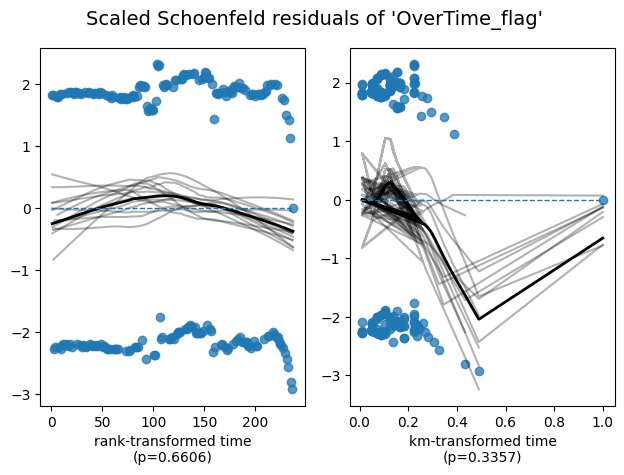

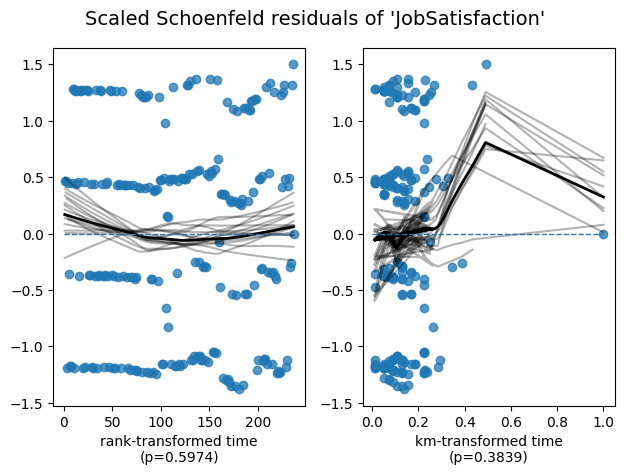

In [ ]:
# Proportional‐Hazards diagnostics

#KM‐transformed test
km_test = proportional_hazard_test(
    cph,
    df2,
    time_transform="km"
)
print("=== KM‐transform proportional‐hazard test ===")
print(km_test.summary)

# Rank‐transformed test
rank_test = proportional_hazard_test(
    cph,
    df2,
    time_transform="rank"
)
print("\n=== Rank‐transform proportional‐hazard test ===")
print(rank_test.summary)

#Full check_assumptions with all covariates shown
cph.check_assumptions(
    df2,
    show_plots=True,
    p_value_threshold=1.0   # show every variable, not just p<0.01
)


לפי התוצאות שקיבלנו, אין סימן לכך שההשפעה של שעות נוספות או שביעות רצון מהעבודה משתנה עם הזמן – כלומר, ההשפעה שלהן על הסיכוי לעזוב את החברה נשארת די קבועה.

בגרפים של שעות נוספות (השורה העליונה), רואים שהנקודות מפוזרות סביב קו ישר, והקו השחור שנמשך לאורך הגרף די שטוח – מה שאומר שהשפעת שעות נוספות על עזיבה לא משתנה עם הזמן.

בגרפים של שביעות רצון מהעבודה (השורה התחתונה), גם כן – אין תבנית ברורה או מגמה משתנה, מה שאומר ששביעות רצון משפיעה על עזיבה באותה צורה לאורך כל תקופת העבודה.